In [1]:
# Generate data for quantile regression.
from __future__ import division
import numpy as np
TRAIN_LEN = 400
SKIP_LEN = 100
TEST_LEN = 50
TOTAL_LEN = TRAIN_LEN + SKIP_LEN + TEST_LEN
m = 10
x0 = np.random.randn(m)
x = np.zeros(TOTAL_LEN) 
x[:m] = x0
for i in range(m+1, TOTAL_LEN):
    x[i] = 1.8*x[i-1] - .82*x[i-2] + np.random.normal()
    
x = np.exp(.05*x + 0.05*np.random.normal(size=TOTAL_LEN))

In [2]:
# Form the quantile regression problem.
from cvxpy import *
w = Variable(m+1)
v = Variable()
tau = Parameter()
error = 0
for i in range(SKIP_LEN, TRAIN_LEN + SKIP_LEN):
    r = x[i] - (w.T*x[i-m-1:i] + v)
    error += 0.5*abs(r) + (tau - 0.5)*r
prob = Problem(Minimize(error))

In [3]:
# Solve quantile regression for different values of tau.
tau_vals = [0.9, 0.5, 0.1]
pred = np.zeros((len(tau_vals), TOTAL_LEN))
r_vals = np.zeros((len(tau_vals), TOTAL_LEN))
for k, tau_val in enumerate(tau_vals):
    tau.value = tau_val
    prob.solve()
    pred[k,:m] = x0
    for i in range(SKIP_LEN, TOTAL_LEN):
        pred[k,i] = (x[i-m-1:i].T*w + v).value
        r_vals[k, i] = (x[i] - (x[i-m-1:i].T*w + v)).value

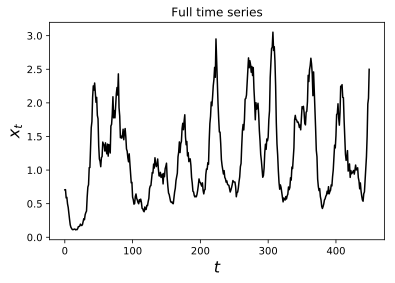

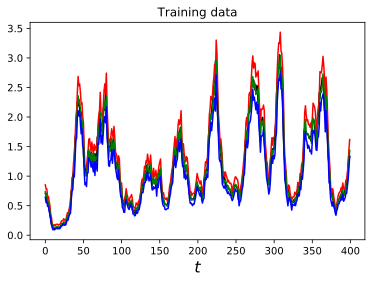

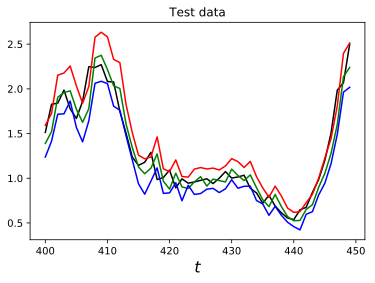

In [4]:
# Generate plots.
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

# Plot the full time series.
plt.plot(range(0, TRAIN_LEN + TEST_LEN), x[SKIP_LEN:],  'black', label=r'$x$')
plt.xlabel(r"$t$", fontsize=16)
plt.ylabel(r"$x_t$", fontsize=16)
plt.title('Full time series')
plt.show()

# Plot the predictions from the quantile regression on the training data.
plt.plot(range(0, TRAIN_LEN), x[SKIP_LEN:-TEST_LEN],  'black', label=r'$x$')
colors = ['r', 'g', 'b']
for k, tau_val in enumerate(tau_vals):
    plt.plot(range(0, TRAIN_LEN), pred[k,SKIP_LEN:-TEST_LEN], colors[k],  label=r"$\tau = %.1f$" % tau_val)
plt.xlabel(r"$t$", fontsize=16)
plt.title('Training data')
plt.show()

# Plot the predictions from the quantile regression on the test data.
plt.plot(range(TRAIN_LEN,TRAIN_LEN+TEST_LEN), x[-TEST_LEN:],  'black', label=r'$x$')
for k, tau_val in enumerate(tau_vals):
    plt.plot(range(TRAIN_LEN,TRAIN_LEN+TEST_LEN), pred[k,-TEST_LEN:], colors[k],  label=r"$\tau = %.1f$" % tau_val)
plt.xlabel(r"$t$", fontsize=16)
plt.title('Test data')
plt.show()

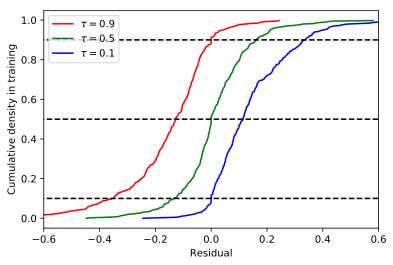

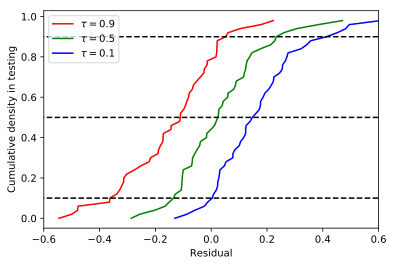

In [5]:
# Plot the empirical CDFs of the residuals.

# Plot the CDF for the training data residuals.
for k, tau_val in enumerate(tau_vals):
    sorted=np.sort(r_vals[k,SKIP_LEN:SKIP_LEN+TRAIN_LEN] )
    yvals=np.arange(len(sorted))/float(len(sorted))
    plt.plot( sorted, yvals, colors[k], label=r"$\tau = %.1f$" % tau_val)

x = np.linspace(-1.0, 1, 100)
for val in [0.1, 0.5, 0.9]:
    plt.plot(x, len(x)*[val], 'k--')
plt.xlabel('Residual')
plt.ylabel('Cumulative density in training')
plt.xlim([-0.6, 0.6])
plt.legend(loc='upper left')
plt.show()

# Plot the CDF for the testing data residuals.
for k, tau_val in enumerate(tau_vals):
    sorted=np.sort(r_vals[k,-TEST_LEN:] )
    yvals=np.arange(len(sorted))/float(len(sorted))
    plt.plot( sorted, yvals, colors[k], label=r"$\tau = %.1f$" % tau_val)

x = np.linspace(-1, 1, 100)
for val in [0.1, 0.5, 0.9]:
    plt.plot(x, len(x)*[val], 'k--')
plt.xlabel('Residual')
plt.ylabel('Cumulative density in testing')
plt.xlim([-0.6, 0.6])
plt.legend(loc='upper left')
plt.show()